**Please insert your full name:** <span style="color:red"> $Hadis$ $Ahmadian$ </span>


**And your student number:**<span style="color:red"> $400211524$ </span>




---



**Project description:**

In this project, we want to create a Covid-19 binary classifier that predicts whether a patient is suffering from Coronavirus or not, using chest CT scans of patients.


please put your final best 
weights in a drive and share its public path with us in jupyter notebook.

we will give to top three models 20 point. 

**1- Import all the libraries you may need here:**

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import shutil

#Add Additional libraries here
from PIL import Image
from matplotlib import cm
import cv2
from matplotlib import pyplot as plt
import torchvision
import sklearn.metrics

random.seed(0)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

Clone dataset and read images

In [2]:
!git clone https://github.com/UCSD-AI4H/COVID-CT
!unzip COVID-CT/Images-processed/CT_COVID.zip
!unzip COVID-CT/Images-processed/CT_NonCOVID.zip

fatal: destination path 'COVID-CT' already exists and is not an empty directory.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
covid_files_path = 'CT_COVID/'
covid_files      = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
non_covid_files_path = 'CT_NonCOVID/'
non_covid_files      = [os.path.join(non_covid_files_path, x) for x in os.listdir(non_covid_files_path)]

In this dataset, We have the positive class with the scans of COVID-19 positive patients, whereas the negative class contains a mixture of healthy patients, and patients suffering from other (non-COVID-19) diseases that may cause opacities in the lungs.

Therefore, a practical classifier would have to differentiate between, say, COVID-19 induced pneumonia and other types of pneumonia.

**2- Show 3 random samples from NonCovid cases and 3 more from Covid cases CT-scans:**(5% point)

*hint: you can use "cv2" library for reading images*

*hint: All samples are stored in the variables "covid_files" and "non_covid_files".*

<span style="color:red"> $NOTE$ </span>
**in below cell I used cv2 AND plt to plot images inside of notebook**

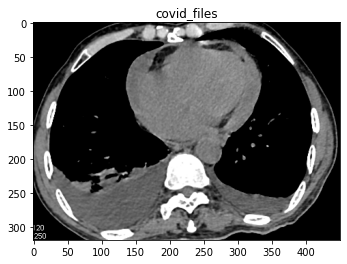

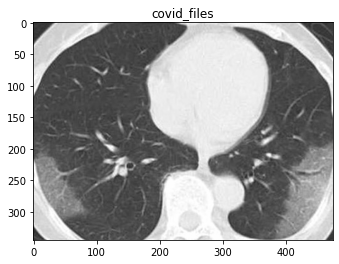

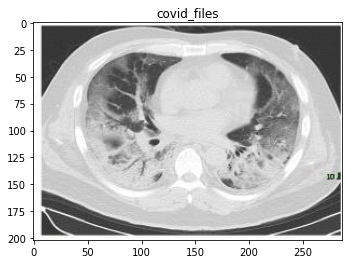

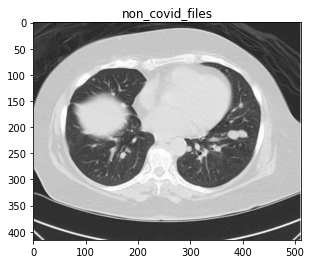

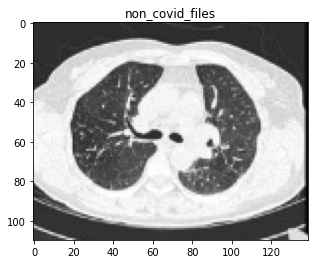

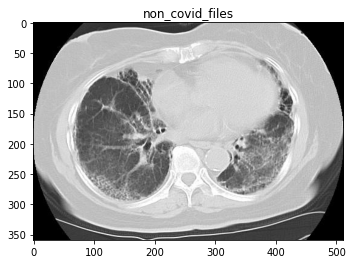

In [4]:
for _ in range(3):
    img = cv2.imread(random.choice(covid_files))

    # Creating GUI window to display an image on screen
    # first Parameter is windows title (should be in string format)
    # Second Parameter is image array
    plt.imshow(img)
    plt.title('covid_files')
    plt.show()
    
for _ in range(3):
    img = cv2.imread(random.choice(non_covid_files))

    # Creating GUI window to display an image on screen
    # first Parameter is windows title (should be in string format)
    # Second Parameter is image array
    plt.imshow(img)
    plt.title('non_covid_files')
    plt.show()

The dataset is divided into three splits: the train set (425 examples), validation set (118 examples), and the test set (203 examples). Information for this split has been provided in the folder Data-split folder.  This folder contains text files which explain what files belong to each split.

We write a function to read these files and put them into a list of strings:

In [6]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

We then create the COVIDCTDataset class which basically subclasses the torch.utils.data.Dataset class:

In [7]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, classes, covid_files, non_covid_files, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.files_path = [non_covid_files, covid_files]
        self.image_list = []

        # read the files from data split text files
        covid_files = read_txt(covid_files)
        non_covid_files = read_txt(non_covid_files)

        # combine the positive and negative files into a cummulative files list
        for cls_index in range(len(self.classes)):
            
            class_files = [[os.path.join(self.root_dir, self.classes[cls_index], x), cls_index] \
                            for x in read_txt(self.files_path[cls_index])]
            self.image_list += class_files
                
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        path = self.image_list[idx][0]
        
        # Read the image
        image = Image.open(path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)

        label = int(self.image_list[idx][1])

        data = {'img':   image,
                'label': label,
                'paths' : path}

        return data

**3- Now you must declare preprocessing transformers for training and testing data(same for validation data)**(20% point)

**NOTE:** *don't change "train_transformer" and "val_transformer" variable names.*

For the training data:

1- Resize the shorter side of the image to 256 while maintaining the aspect ratio.

2- Do a random crop of size ranging from 50% to 100% of the dimensions of the image, and aspect ratio ranging randomly from 75% to 133% of the original aspect ratio. Finally, the crop is resized to 224 × 224.

3- Horizontally flip the image with a probability of 0.5.

4- Convert it to Tensor.

5- Normalize the image to have 0 mean and standard deviation of 1

In [8]:
train_transformer = torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                                    torchvision.transforms.RandomResizedCrop(244, scale=(0.5, 1.0), ratio=(0.75, 1.33)),
                                                    torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize(0, 1)])

For testing:

1- Resize the image to 224 × 224.

2- Convert in to Tensor.

3- Normalize the image to have mean 0 and standard deviation of 1

In [9]:
val_transformer = torchvision.transforms.Compose([torchvision.transforms.Resize((244,244)),
                                                   torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize(0, 1)])

With our Dataset and DataLoader classes defined, let us now instantiate them. We use the label 0 for the non-COVID cases, whereas we use 1 for the COVID positive cases.

In [10]:
batchsize = 8

trainset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/trainCT_COVID.txt',
                          non_covid_files='Data-split/NonCOVID/trainCT_NonCOVID.txt',
                          transform= train_transformer)
valset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/valCT_COVID.txt',
                          non_covid_files = 'Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform= val_transformer)
testset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/testCT_COVID.txt',
                          non_covid_files='Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform= val_transformer)

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

**4- Now declare a function for calculating these metrics for every training epoch:**(15% point)

**Accuracy,Sensitivity,Specificity,Area under ROC,Confusion Matrix, and Validation Loss**

In [11]:
def cal_epoch(y_true,y_pred):
    conf_mat = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print("confiusion matrix:\n",conf_mat)
    accuracy=sklearn.metrics.accuracy_score(y_true, y_pred)
    print("accuracy:",accuracy)
    sensitivity = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0])
    print("sensitivity:",sensitivity)
    specificity = conf_mat[0,0]/(conf_mat[0,1]+conf_mat[0,0])
    print("specificity:",specificity)
    roc_auc_score=sklearn.metrics.roc_auc_score(y_true, y_pred)
    print("ROC:",roc_auc_score)
    loss=sklearn.metrics.log_loss(y_true, y_pred)
    print("loss:",loss)

**5-We now define our model. Use your preferred pretrained model(VGG19,ResNet,DenseNet etc.)**(20% point)

<span style="color:red"> $NOTE$ </span>

**chosen model** :
i tried all 3 suggested pre-trained networks. Resnet and Densnet had the problem of extreem overfitting even when I used a large  weight_decay, so finall choice vas **VGG19**

In [65]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)

Using cache found in C:\Users\Mrs/.cache\torch\hub\pytorch_vision_v0.10.0


We then replace its final linear layer with one having 2 neurons at its output, and perform transfer learning over our dataset.

In [66]:
model.classifier[6] = nn.Linear(4096, 2)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

**6- Set the training hyperparameters and optimizer:**(10% point)

<span style="color:red"> $NOTE$ </span>

**hyperparameters** :
after a bunch of times of running I reached my best accuracy on validation set by:
1. learning rate=1e-5
2. weight_decay=1e-2
3. loss function=CrossEntropyLoss (aka log loss)
4. optimizer= Adam

In [67]:
learning_rate = 1e-5
num_epochs=25
num_batchs = len(train_loader)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-2)

**7-Now train the model and save the model(check every epoch) with best validation accuracy:**(20% point)

<span style="color:red"> $NOTE$ </span>
in every batch I reported loss, **averaged over training batches** however for validation and test I reported **sum over batches** that's why valid loss is so higher, you should just devide it by 10 if you wanna compare it to train loss.

In [68]:
model.train()
for epoch in range(num_epochs):
    print("epoch :",epoch+1)
    total_train=0
    correct_train=0
    running_loss = 0.0
    for batch, inputs in enumerate(train_loader, 0):
        data=inputs["img"]
        labels=inputs["label"]
        # zero the parameter gradients:
        optimizer.zero_grad()
        # forward pass:
        out=model(data)
        
        loss=criterion(out,labels)
        # backward pass:
        loss.backward()
        # optimization:
        optimizer.step()
        
        outputs=model(data)
        
        # Results: 
        running_loss += loss.item()

        total_train += labels.size(0)
        _, predicted_train = torch.max(outputs.data, 1)
        correct_train += (predicted_train == labels.to(device)).sum().item()

        if batch % 10 == 0:
            print('[Batch %d / %d of epoch %d] loss: %.3f' %
                  (batch + 1, num_batchs,epoch+1 ,running_loss / (num_batchs/10)))
            running_loss = 0.0
            torch.save(model.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')
    y_pred_val = []
    y_true_val = []
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images=data["img"]
            labels=data["label"]

            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            
            y_pred_val+=predicted.tolist()
            y_true_val+=labels.tolist()
            total += labels.size(0)
            
            correct += (predicted == labels.to(device)).sum().item()
    val_acc = correct / total
    train_acc = correct_train / total_train
    print('(Epoch %d / %d) train acc: %.2f%%; val_acc: %.2f%%' % (
          epoch+1, num_epochs, 100*train_acc, 100*val_acc))
    print("Validation Metrics : ")       
    cal_epoch(y_true_val,y_pred_val)
    train_acc = correct_train / total_train

    print("****************************************************************")

epoch : 1
[Batch 1 / 54 of epoch 1] loss: 0.134
[Batch 11 / 54 of epoch 1] loss: 1.283
[Batch 21 / 54 of epoch 1] loss: 1.242
[Batch 31 / 54 of epoch 1] loss: 1.254
[Batch 41 / 54 of epoch 1] loss: 1.132
[Batch 51 / 54 of epoch 1] loss: 1.118
(Epoch 1 / 25) train acc: 60.47%; val_acc: 58.47%
Validation Metrics : 
confiusion matrix:
 [[36 22]
 [27 33]]
accuracy: 0.5847457627118644
sensitivity: 0.55
specificity: 0.6206896551724138
ROC: 0.5853448275862069
loss: 14.342522326221085
****************************************************************
epoch : 2
[Batch 1 / 54 of epoch 2] loss: 0.088
[Batch 11 / 54 of epoch 2] loss: 1.225
[Batch 21 / 54 of epoch 2] loss: 1.064
[Batch 31 / 54 of epoch 2] loss: 0.993
[Batch 41 / 54 of epoch 2] loss: 1.000
[Batch 51 / 54 of epoch 2] loss: 0.901
(Epoch 2 / 25) train acc: 72.94%; val_acc: 61.02%
Validation Metrics : 
confiusion matrix:
 [[49  9]
 [37 23]]
accuracy: 0.6101694915254238
sensitivity: 0.38333333333333336
specificity: 0.8448275862068966
ROC: 

**8- For testing, use your best model and compute performance metrics:**(5% point)

<span style="color:red"> $NOTE$ </span>
reported loss on test is **sum over batches** that's why test loss is so higher, you should just devide it by 10 if you wanna compare it to train loss.

In [69]:
y_pred_tst = []
y_true_tst = []
with torch.no_grad():
    for data in test_loader:
        images=data["img"]
        labels=data["label"]
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        y_pred_tst+=predicted.tolist()
        y_true_tst+=labels.tolist()
    
cal_epoch(y_true_tst,y_pred_tst)

confiusion matrix:
 [[88 17]
 [28 70]]
accuracy: 0.7783251231527094
sensitivity: 0.7142857142857143
specificity: 0.8380952380952381
ROC: 0.7761904761904762
loss: 7.656445965159084


**9- Print the confusion matrix of the model:**(5% point)

In [2]:
print("confusion matrix was printed in the cell above =) ")

confusion matrix was printed in the cell above =) 
